In [32]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file

img_size = 128
ages=['0-10', '11-20', '21-45', '46-60', '60-100']

pretrained_model = "https://files.seeedstudio.com/ml/age_gender/weights.46-0.73.hdf5"
modhash = '90875017ac84552e4f1a828629053064f3d3ebf5'

test_dataset_path = '../data/processed_data/test.csv'

def age_to_groups(age):

    for group in ages:
        if age >= int(group.split('-')[0]) and age <= int(group.split('-')[1]):
            age = ages.index(group)

    return age

def load_data(path, rebalance = False):

    d = pd.read_csv(path)
    
    for i, row in d.iterrows():
        d.at[i, 'age'] = age_to_groups(d.at[i, 'age'])
        #d.at[i, 'gender'] = gender_to_groups(d.at[i, 'gender'])

    if rebalance:
        print('Samples before rebalance: {}'.format(len(d)))    
        d = rebalance_data(d, 'age')    
        print('Samples after rebalance: {}'.format(len(d)))

    return d["file"].to_numpy(), d["gender"].to_numpy(), d["age"].to_numpy()



# download model
model_file = get_file("MobileFaceNet_128_2_0-73.hdf5", pretrained_model, cache_subdir="pretrained_models",
                        file_hash=modhash)

# load test data
test_image_list, test_gender, test_ages = load_data(test_dataset_path, False)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 90875017ac84552e4f1a828629053064f3d3ebf5 so we will re-download the data.
10051584/10050216 [==============================] - 2s 0us/step


<ipython-input-36-56af48b55086>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  orig_faces = np.empty(shape = (img_num, img_size, img_size, 3), dtype=np.int)


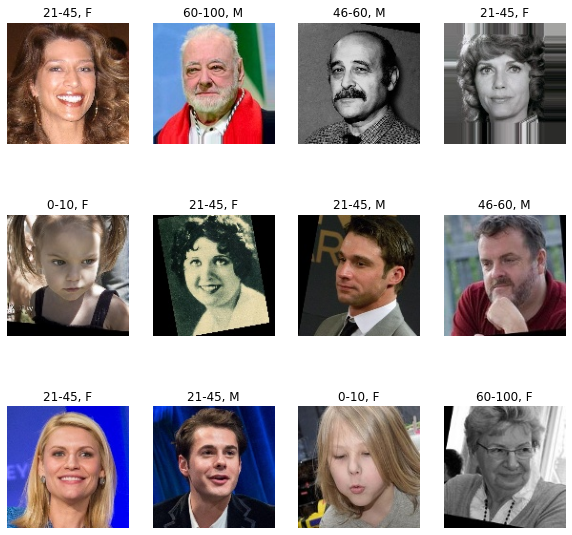

In [36]:
cols, rows = 4, 3
img_num = cols * rows
path_root = "../data/processed_data/test"
img_ids = np.random.choice(len(test_image_list), img_num)
orig_faces = np.empty(shape = (img_num, img_size, img_size, 3), dtype=np.int)

for i in range(len(img_ids)):
    img = cv2.imread(os.path.join(path_root, test_image_list[img_ids[i]]))
    orig_faces[i, :, :, :] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

faces = orig_faces.copy()
faces = faces.astype(np.float32)
faces /=  255.
faces -= 0.5
faces *= 2.

model = load_model(model_file)

# predict
results = model.predict(faces)
predicted_genders = results[0]
predicted_ages = np.argmax(results[1], axis = 1)

plt.rcParams["figure.figsize"] = (10,10)

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(orig_faces[i])
    plt.title("{}, {}".format(ages[predicted_ages[i]], "M" if predicted_genders[i][0] < 0.5 else "F"))
    plt.axis('off')
plt.savefig("result.png")